# NATURAL LANGUAGE PROCESSING

### FINAL PROJECT CODE

By - Bowen Zhao, Jacqueline Zhao, Nikhila Kulukuru, Yiran (Vic) Cao

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sec_api import ExtractorApi
import regex as re
import yfinance as yf
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.cluster import KMeans
from pyminimax import minimax
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram
from pyminimax import fcluster_prototype
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold

In this project, we are addressing a finance problem related the movement of the stock price of the S&P 500 companies using their 2022 year-end 10K filings. This problem is intriguing and important because understanding the relationship between financial disclosures and stock price movements can offer valuable insights for investors and stakeholders. We believe NLP techniques are highly relevant for this task, as they can extract and quantify subtle semantic cues and patterns from the vast textual data in 10-K filings, potentially highlight predictive indicators of stock performance.

## Section 1 - Explanatory Data Analysis

In our text data, a document is the text of the MDMA section of a 10-K filing. Each observational unit of text is the entire MDMA paragraph which a part of the 10-K filing. We are working with 495 documents. Our aim was to work with all companies in the S&P 500. However, some companies are missing 2022 10-K filings and hence we are only working with 495 filings. We decided to use stemming while creating the final word frequencies document term matrix.

Before we create the document-term matrix, we want to extract the 10-K filings using the SEC API and clean the text.

In [2]:
#Reading the URLs for the S&P 500 10K filings for the year 2022
urls = pd.read_csv('url.csv')

In [3]:
urls = urls[urls['formType'] == '10-K']
urls = urls[urls['year'] == 2022]
print(urls.shape)
urls.head()

(495, 6)


,ticker,cik,formType,year,filedAt,filingUrl
493,A,1090872,10-K,2022,2022-12-20T18:42:30-05:00,https://www.sec.gov/Archives/edgar/data/109087...
494,AMAT,6951,10-K,2022,2022-12-16T16:50:05-05:00,https://www.sec.gov/Archives/edgar/data/6951/0...
495,AVGO,1730168,10-K,2022,2022-12-16T16:21:52-05:00,https://www.sec.gov/Archives/edgar/data/173016...
496,BDX,10795,10-K,2022,2022-11-22T16:58:28-05:00,https://www.sec.gov/Archives/edgar/data/10795/...
497,APD,2969,10-K,2022,2022-11-22T16:37:46-05:00,https://www.sec.gov/Archives/edgar/data/2969/0...


In [4]:
extractorApi = ExtractorApi("105d85762b9138da11aa136b3313112c93888324437c9aff80c3babfa607ac34")
companies = pd.DataFrame(columns = ['ticker', 'mdma'])

#Analyze the sentiment expressed in the management discussion and analysis (MD&A) section of 10K .
#This can help investors gauge management's outlook and sentiment regarding the company's performance.
count = 0
for i in urls['filingUrl']:
    #get the MDMA section only
    item_7_text = extractorApi.get_section(i, "7", "text")

    row = urls.iloc[count]
    companies.loc[count] = [row['ticker'], item_7_text]
    count+=1

In [5]:
companies.head()

,ticker,mdma
0,A,Item 7. Management's Discussion and Analysis ...
1,AMAT,Item 7: Management&#8217;s Discussion and Ana...
2,AVGO,ITEM 7. MANAGEMENT&#8217;S DISCUSSION AND ANA...
3,BDX,Item 7. Management&#8217;s Discussion and Ana...
4,APD,Item 7. Management's Discussion and Analysis ...


In [6]:
#Now we clean our text a bit using various regex functions
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#function for removing all the scrub words
def scrub_words(text):
    #Replace \xao characters in text
    text = re.sub('\xa0', ' ', text)

    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)

    #Replace new line characters and following text until space
    text = re.sub('\n(\w*?)[\s]', '', text)

    #Remove html markup
    text = re.sub("<.*?>", ' ', text)

    #Remove extra spaces from the text
    text = re.sub("\s+", ' ', text)
    return text

In [8]:
#removing accented characters
companies['mdma'] = [remove_accented_chars(text) for text in companies['mdma']]

#re-placing " " " with space
companies['mdma'] = [text.replace('"', '') for text in companies['mdma']]

# Removing url's from the text
url_reg  = r'[a-z]*[:.]+\S+'
companies['mdma'] = [re.sub(url_reg, '', text) for text in companies['mdma']]

companies['mdma'] = [re.sub(r"\b[a-zA-Z]\b", "", text) for text in companies['mdma']]

#removing scrub_words
companies['mdma'] = [scrub_words(text) for text in companies['mdma']]

#replace spaaces more than one with single space
companies['mdma'] = [re.sub("\s+", ' ', text) for text in companies['mdma']]

#finding the length of the words in the data
companies['count'] = [len(text.split(' ')) for text in companies['mdma']]

In [9]:
companies.head()

,ticker,mdma,count
0,A,Item Management Discussion and Analysis of Fi...,13889
1,AMAT,Item Management Discussion and Analysis of Fi...,8967
2,AVGO,ITEM MANAGEMENT DISCUSSION AND ANALYSIS OF FI...,6840
3,BDX,Item Management Discussion and Analysis of Fi...,11649
4,APD,Item Management Discussion and Analysis of Fi...,14102


In [10]:
#Now we try to get the value of the stock price on 1st December 2022 and 31st December 2022
companies['stockPrice1'] = 0
companies['stockPrice2'] = 0

for i in range(len(companies)):
  stock_symbol = companies['ticker'][i]
  startdate = "2022-12-01"
  enddate = "2022-12-31"

  ticker = yf.Ticker(stock_symbol)

  historical_data = ticker.history(start=startdate, end=enddate)

  if len(historical_data) != 0:
    companies['stockPrice1'][i] = historical_data['Close'][0]
    companies['stockPrice2'][i] = historical_data['Close'][-1]

/var/folders/l9/gfrx15l17mb69q1whm7v0dh80000gn/T/ipykernel_37274/2288393656.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['stockPrice1'][i] = historical_data['Close'][0]
/var/folders/l9/gfrx15l17mb69q1whm7v0dh80000gn/T/ipykernel_37274/2288393656.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['stockPrice2'][i] = historical_data['Close'][-1]
BRK.B: No timezone found, symbol may be delisted


In [11]:
#We find the price move between the 2 dates and then encode the target variable to 0/1 based on the price move
companies['diff'] = companies['stockPrice2'] - companies['stockPrice1']
companies['priceMove'] = np.where(companies['diff'] > 0, 1, 0)

In [12]:
#We notice that the first few words of every document is the heading of the MDMA section and hence the same -
#this may lead to incorrect analysis in the future so we remove the first few characters of every string
companies['finalText'] = companies['mdma'].str[90:]

In [13]:
companies.head()

,ticker,mdma,count,stockPrice1,stockPrice2,diff,priceMove,finalText
0,A,Item Management Discussion and Analysis of Fi...,13889,155.024765,148.821777,-6.202988,0,The following discussion should be read in con...
1,AMAT,Item Management Discussion and Analysis of Fi...,8967,106.255081,96.693016,-9.562065,0,Introduction Management Discussion and Analysi...
2,AVGO,ITEM MANAGEMENT DISCUSSION AND ANALYSIS OF FI...,6840,536.493835,549.201416,12.707581,1,This Management Discussion and Analysis of Fin...
3,BDX,Item Management Discussion and Analysis of Fi...,11649,247.192551,251.540909,4.348358,1,The following commentary should be read in con...
4,APD,Item Management Discussion and Analysis of Fi...,14102,304.772552,302.655090,-2.117462,0,TABLE_START Business Overview in Summary Outlo...


In [14]:
companies.priceMove.value_counts() #unbalanced dataset

0    414
1     81
Name: priceMove, dtype: int64

In [15]:
#We now make a word count table using the finalText column
#We first create tokens, remove the stop words and then using stemming on the tokens

companies['tokens'] = companies.finalText.apply(nltk.word_tokenize)

def remove_stop_words(new_text):
    result = [w.lower() for w in new_text if w.lower() not in ENGLISH_STOP_WORDS]
    return result

companies['no_stop_words'] = companies.tokens.apply(remove_stop_words)

stemmer = PorterStemmer()

def stem_words(tokens):
    return [stemmer.stem(w) for w in tokens]

companies['post_stemming'] = companies.no_stop_words.apply(stem_words)
companies.head()

,ticker,mdma,count,stockPrice1,stockPrice2,diff,priceMove,finalText,tokens,no_stop_words,post_stemming
0,A,Item Management Discussion and Analysis of Fi...,13889,155.024765,148.821777,-6.202988,0,The following discussion should be read in con...,"[The, following, discussion, should, be, read,...","[following, discussion, read, conjunction, con...","[follow, discuss, read, conjunct, consolid, fi..."
1,AMAT,Item Management Discussion and Analysis of Fi...,8967,106.255081,96.693016,-9.562065,0,Introduction Management Discussion and Analysi...,"[Introduction, Management, Discussion, and, An...","[introduction, management, discussion, analysi...","[introduct, manag, discuss, analysi, financi, ..."
2,AVGO,ITEM MANAGEMENT DISCUSSION AND ANALYSIS OF FI...,6840,536.493835,549.201416,12.707581,1,This Management Discussion and Analysis of Fin...,"[This, Management, Discussion, and, Analysis, ...","[management, discussion, analysis, financial, ...","[manag, discuss, analysi, financi, condit, res..."
3,BDX,Item Management Discussion and Analysis of Fi...,11649,247.192551,251.540909,4.348358,1,The following commentary should be read in con...,"[The, following, commentary, should, be, read,...","[following, commentary, read, conjunction, con...","[follow, commentari, read, conjunct, consolid,..."
4,APD,Item Management Discussion and Analysis of Fi...,14102,304.772552,302.655090,-2.117462,0,TABLE_START Business Overview in Summary Outlo...,"[TABLE_START, Business, Overview, in, Summary,...","[table_start, business, overview, summary, out...","[table_start, busi, overview, summari, outlook..."


In [16]:
#Now we join the tokens post removing stop words and stemming

def join_tokens(tokens):
    return " ".join(tokens)

companies['new_text'] = companies.post_stemming.apply(join_tokens)
companies.head()

,ticker,mdma,count,stockPrice1,stockPrice2,diff,priceMove,finalText,tokens,no_stop_words,post_stemming,new_text
0,A,Item Management Discussion and Analysis of Fi...,13889,155.024765,148.821777,-6.202988,0,The following discussion should be read in con...,"[The, following, discussion, should, be, read,...","[following, discussion, read, conjunction, con...","[follow, discuss, read, conjunct, consolid, fi...",follow discuss read conjunct consolid financi ...
1,AMAT,Item Management Discussion and Analysis of Fi...,8967,106.255081,96.693016,-9.562065,0,Introduction Management Discussion and Analysi...,"[Introduction, Management, Discussion, and, An...","[introduction, management, discussion, analysi...","[introduct, manag, discuss, analysi, financi, ...",introduct manag discuss analysi financi condit...
2,AVGO,ITEM MANAGEMENT DISCUSSION AND ANALYSIS OF FI...,6840,536.493835,549.201416,12.707581,1,This Management Discussion and Analysis of Fin...,"[This, Management, Discussion, and, Analysis, ...","[management, discussion, analysis, financial, ...","[manag, discuss, analysi, financi, condit, res...",manag discuss analysi financi condit result op...
3,BDX,Item Management Discussion and Analysis of Fi...,11649,247.192551,251.540909,4.348358,1,The following commentary should be read in con...,"[The, following, commentary, should, be, read,...","[following, commentary, read, conjunction, con...","[follow, commentari, read, conjunct, consolid,...",follow commentari read conjunct consolid finan...
4,APD,Item Management Discussion and Analysis of Fi...,14102,304.772552,302.655090,-2.117462,0,TABLE_START Business Overview in Summary Outlo...,"[TABLE_START, Business, Overview, in, Summary,...","[table_start, business, overview, summary, out...","[table_start, busi, overview, summari, outlook...",table_start busi overview summari outlook resu...


In [17]:
companies.shape

(495, 12)

## Section 2 - Unsupervised Learning

Now, to understand the structure of our data better, we apply some unsupervised learning techniques on the stemmed text. In particular, we run K-Mean Clustering, NMF and LSA techniques. 

In [18]:
#We now create a document term matrix using word frequencies on data after stemming
#Now we remove all the numbers and the words that do not look like English
word_vectorizer = CountVectorizer(token_pattern = '[a-zA-Z]+')

word_bow_matrix = word_vectorizer.fit_transform(companies['new_text'])
word_bow_df = pd.DataFrame(word_bow_matrix.toarray(),
                           columns = word_vectorizer.get_feature_names_out())
# View the first five rows:
word_bow_df.head()

,aa,aaa,aacl,aad,aadvantag,aag,aal,aami,aamt,aao,...,zrcc,zte,ztna,zuranolon,zurich,zydelig,zydi,zynga,zyprexa,zytiga
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are 23251920 words across all documents in the dataset.


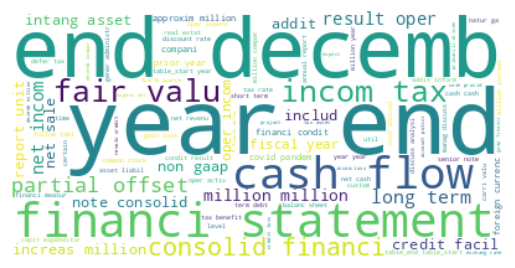

In [19]:
wc = WordCloud(background_color = "white", max_words = 2000)

text = " ".join(doc for doc in companies.new_text)
print ("There are {} words across all documents in the dataset.".format(len(text)))

# Generate word cloud for the full dataset:
stem_wc = wc.generate(text)
plt.imshow(stem_wc, interpolation = 'bilinear')
plt.axis("off")
plt.show()

The above word cloud shows us the most important words across all documents after stop words are removed. We do not see any surprises in the large words. The 10-K filing is a year-end financial filing and hence having words such as 'year end', 'cash flow', 'decemb' etc make perfect sense. Other words such as 'increas', 'net sale', 'oper income' etc which are highlighted may be important as well while classifying the documents.

### K - Means Clustering

In [20]:
# We run K Means Clustering on K = 2,5,10
# k=2
word_matrix = preprocessing.normalize(word_bow_df)
k_means_word = KMeans(n_clusters = 2, random_state = 42)
k_means_word.fit(word_matrix)

np.unique(k_means_word.labels_, return_counts = True)

/Users/nikhilakulukuru/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1], dtype=int32), array([465,  30]))

<Axes: xlabel='cluster'>

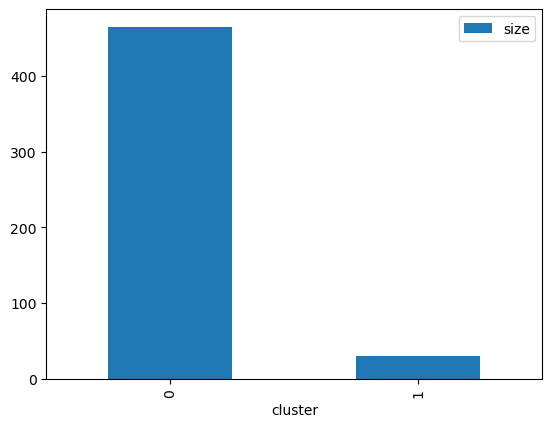

In [21]:
sizes = []
for i in range(2):
    sizes.append({"cluster": i, "size": np.sum(k_means_word.labels_ == i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar()

In [22]:
def wordcloud_clusters(model, vectors, features, n_top_words = 50):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis = 0)
        largest = words.argsort()[::-1]
        for i in range(0, n_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color = "white", max_words = 100,
                      width = 500, height = 300)
        wc.generate_from_frequencies(size)
        plt.figure(figsize = (4, 4))
        plt.imshow(wc, interpolation = "bilinear")
        plt.axis("off")

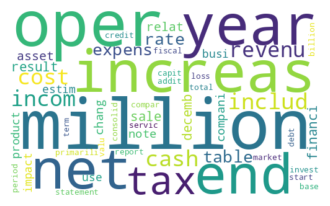

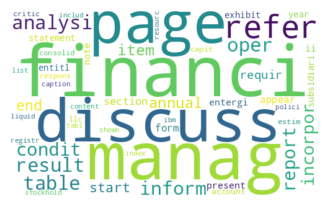

In [23]:
wordcloud_clusters(k_means_word, word_matrix,
                   word_bow_df.columns.values)

In [24]:
#k=5
k_means_word5 = KMeans(n_clusters = 5, random_state = 42)
k_means_word5.fit(word_matrix)

np.unique(k_means_word5.labels_, return_counts = True)

/Users/nikhilakulukuru/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 3, 4], dtype=int32), array([ 88,  30,  64,  34, 279]))

<Axes: xlabel='cluster'>

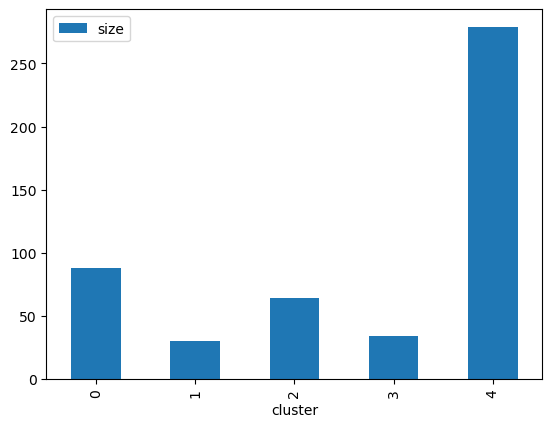

In [25]:
sizes = []
for i in range(5):
    sizes.append({"cluster": i, "size": np.sum(k_means_word5.labels_ == i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar()

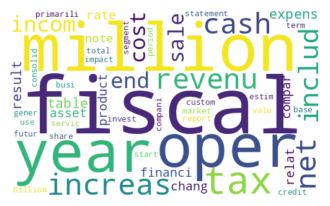

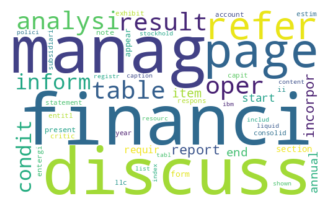

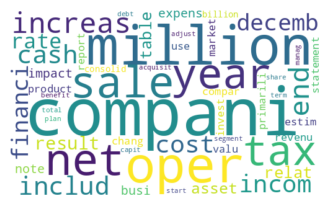

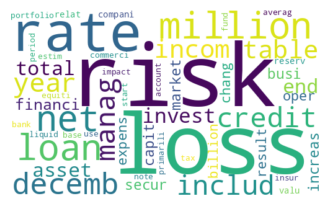

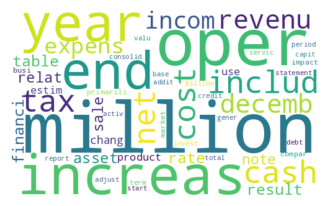

In [26]:
wordcloud_clusters(k_means_word5, word_matrix,
                   word_bow_df.columns.values)

In [27]:
#k=10
k_means_word10 = KMeans(n_clusters = 10, random_state = 42)
k_means_word10.fit(word_matrix)

np.unique(k_means_word10.labels_, return_counts = True)

/Users/nikhilakulukuru/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 31,  37,  67, 105,  11,  53,  35,  87,  50,  19]))

<Axes: xlabel='cluster'>

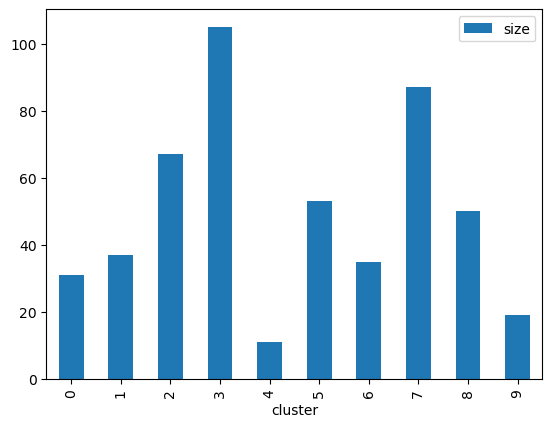

In [28]:
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means_word10.labels_ == i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar()

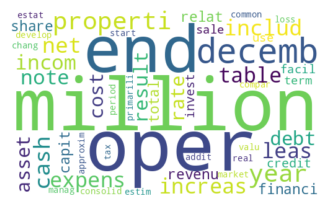

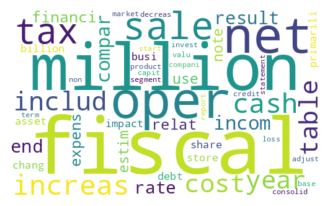

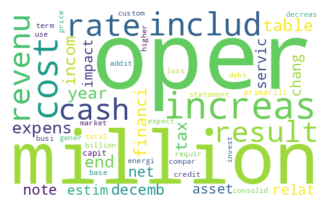

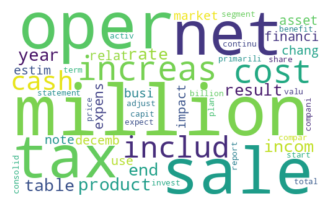

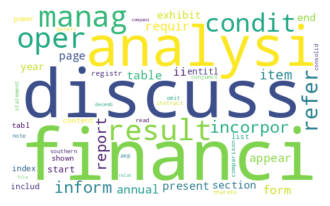

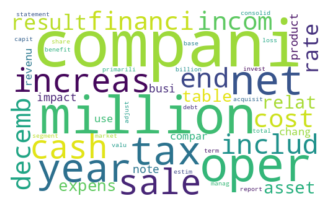

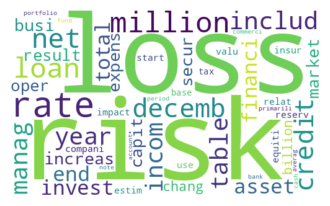

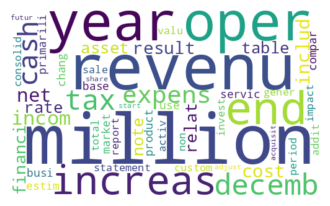

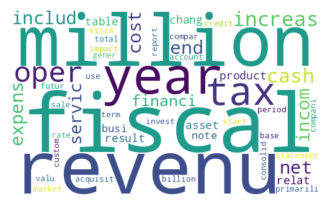

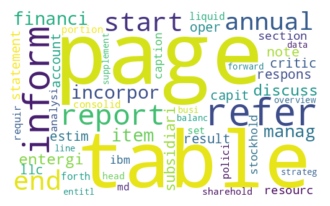

In [29]:
wordcloud_clusters(k_means_word10, word_matrix,
                   word_bow_df.columns.values)

We create bar plot of the quantity of the various clusters using k = 2,5,10. We see that the bar plot with k = 5 and k = 10 gives us somewhat well partitioned clusters some of bigger sizes and some of smaller sizes.

After creating word clouds of the different clusters, we can see that the word clouds for the clustering with k = 5 gives us the best division of topics. The words highlighted are meaningful to predict the response variable.

### NMF

In [30]:
nmf_word_model = NMF(n_components = 5, random_state = 42)
# Access the W matrix with document to topic mapping
W_word_matrix = nmf_word_model.fit_transform(word_bow_df)
H_word_matrix = nmf_word_model.components_

/Users/nikhilakulukuru/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [31]:
def display_topics(model, features, n_top_words = 10):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print("\nTopic %02d" % topic)
        for i in range(0, n_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],
                                  word_vector[largest[i]]*100.0 / total))

In [32]:
display_topics(nmf_word_model, word_bow_df.columns.values)


Topic 00
 oper (1.40)
 tax (1.24)
 net (1.15)
 sale (1.06)
 cash (1.03)
 increas (1.00)
 product (0.99)
 cost (0.97)
 includ (0.97)
 fiscal (0.94)

Topic 01
 risk (2.30)
 loan (1.75)
 manag (1.42)
 credit (1.36)
 rate (1.16)
 decemb (1.12)
 table (0.98)
 asset (0.98)
 total (0.96)
 capit (0.90)

Topic 02
 loss (3.06)
 insur (1.46)
 reserv (1.43)
 invest (1.37)
 year (1.08)
 claim (1.06)
 net (1.03)
 premium (1.00)
 reinsur (1.00)
 expens (0.94)

Topic 03
 million (2.68)
 oper (1.36)
 decemb (1.33)
 end (1.30)
 increas (1.15)
 year (1.09)
 cost (1.08)
 revenu (0.97)
 table (0.92)
 rate (0.90)

Topic 04
 compani (7.54)
 million (2.53)
 net (1.37)
 sale (1.23)
 oper (1.13)
 decemb (1.10)
 tax (0.85)
 year (0.85)
 relat (0.84)
 financi (0.83)


In [33]:
W_word_matrix.sum(axis = 0) / W_word_matrix.sum() * 100.0

array([52.47223361,  9.51676417,  8.15211981, 18.72140973, 11.13747268])

### LSA

In [34]:
#components = 5
svd_word_model = TruncatedSVD(n_components = 5, random_state = 42)
W_svd_fomc_matrix = svd_word_model.fit_transform(word_bow_df)
H_svd_fomc_matrix = svd_word_model.components_

display_topics(svd_word_model, word_bow_df.columns.values)


Topic 00
 million (1.35)
 oper (1.07)
 net (0.95)
 year (0.89)
 includ (0.89)
 end (0.86)
 increas (0.85)
 rate (0.84)
 incom (0.79)
 table (0.77)

Topic 01
 risk (19.67)
 loan (12.62)
 loss (10.96)
 manag (9.65)
 credit (8.44)
 secur (6.82)
 total (5.38)
 reserv (5.28)
 bank (4.97)
 insur (4.86)

Topic 02
 loss (-130.73)
 compani (-81.54)
 insur (-69.55)
 reserv (-66.76)
 claim (-59.37)
 reinsur (-52.40)
 premium (-51.02)
 invest (-44.71)
 line (-32.29)
 catastroph (-31.74)

Topic 03
 million (-32.11)
 decemb (-18.15)
 loan (-10.37)
 properti (-9.07)
 energi (-7.81)
 compani (-7.41)
 electr (-6.89)
 loss (-6.82)
 end (-6.42)
 leas (-6.18)

Topic 04
 compani (-14.15)
 loan (-6.03)
 sale (-3.54)
 fiscal (-3.21)
 net (-3.05)
 million (-2.77)
 year (-1.58)
 bancorp (-1.57)
 leas (-1.50)
 commerci (-1.49)


In [35]:
svd_word_model.singular_values_

array([9765.20641954, 2970.11013489, 2216.88127258, 1603.03735827,
       1557.16560491])

In [36]:
#components = 10
svd_word_model = TruncatedSVD(n_components = 10, random_state = 42)
W_svd_fomc_matrix = svd_word_model.fit_transform(word_bow_df)
H_svd_fomc_matrix = svd_word_model.components_

display_topics(svd_word_model, word_bow_df.columns.values)


Topic 00
 million (1.35)
 oper (1.07)
 net (0.95)
 year (0.89)
 includ (0.89)
 end (0.86)
 increas (0.85)
 rate (0.84)
 incom (0.79)
 table (0.77)

Topic 01
 risk (19.67)
 loan (12.62)
 loss (10.96)
 manag (9.65)
 credit (8.44)
 secur (6.82)
 total (5.38)
 reserv (5.28)
 bank (4.97)
 insur (4.86)

Topic 02
 loss (-130.72)
 compani (-81.53)
 insur (-69.54)
 reserv (-66.76)
 claim (-59.36)
 reinsur (-52.39)
 premium (-51.01)
 invest (-44.71)
 line (-32.29)
 catastroph (-31.74)

Topic 03
 million (-32.17)
 decemb (-18.18)
 loan (-10.38)
 properti (-9.08)
 energi (-7.81)
 compani (-7.42)
 electr (-6.90)
 loss (-6.83)
 end (-6.43)
 leas (-6.19)

Topic 04
 compani (-14.17)
 loan (-6.04)
 sale (-3.57)
 fiscal (-3.20)
 net (-3.08)
 million (-2.75)
 bancorp (-1.55)
 year (-1.54)
 leas (-1.51)
 commerci (-1.50)

Topic 05
 year (-7.01)
 revenu (-6.41)
 fiscal (-6.02)
 end (-5.77)
 loss (-3.63)
 expens (-3.53)
 properti (-3.07)
 decemb (-3.02)
 leas (-2.07)
 servic (-1.90)

Topic 06
 table (-243.

In [37]:
svd_word_model.singular_values_

array([9765.20641954, 2970.11013489, 2216.88127392, 1603.03768857,
       1557.18199342, 1476.31428167, 1432.79245838, 1289.88120099,
       1244.63507642, 1200.10060241])

Our final methods of choice are K means and LSA. We are using K means because when we only have two labels 0 and 1 representing if the stock price went up or down there is a clear division in the data. However, we also try the case where k = 5 or k = 10. In these 2 cases, we are not sure about the performance of the clustering algorithm. We will later confirm the validity of the k using the word clouds and other graphical methods. In addition, K-means is computationally efficient and works well with our high dimensional data and hence it is one of the unsupervised methods we pick.

On the other hand, Minimax linkage is useful for visualizing the hierarchical relationships between clusters. However, the minimax linkage does not deal well with our high dimensional data as it is computationally inefficient.

NMF and LSA are also not the best choice for us because our primary goal is a strict partitioning of documents into clusters. However, we will also use LSA to help with discovering the latent sementic structure within the document matrix. As we can see, the LSA with 5 clusters models topics that effectively implies price move. Therefore, we will include LSA for feature engineering to reduce dimensionality and capture semantic patterns before applying K-means clustering.

### Representative Documents

In [38]:
centroids = k_means_word5.cluster_centers_
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
similarities = cosine_similarity(centroids, word_matrix)

# Find the index of the document with maximum similarity for each centroid
closest_to_cen = similarities.argmax(axis=1)


In [39]:
comp_documents = companies.new_text.tolist()
for cluster_idx, doc_idx in enumerate(closest_to_cen):
    print(f"Cluster {cluster_idx} representative document:")
    print(comp_documents[doc_idx][:500])
    print("\n")

Cluster 0 representative document:
follow discuss analysi financi condit result oper read conjunct consolid financi statement relat note appear ii item annual report form discuss contain forward look statement base current expect involv risk uncertainti actual result differ materi anticip forward look statement result factor includ set forth item risk factor report forward look inform immedi preced strategi autodesk chang world design technolog span architectur engin construct product design manufactur media entertain empow innov


Cluster 1 representative document:
table_end inform requir item appear manag discuss analysi financi condit result oper annual report incorpor refer table_start


Cluster 2 representative document:
follow discuss analysi contain forward look statement includ limit statement relat plan strategi object expect intent resourc forward look statement read conjunct disclosur item risk factor form section form gener discuss result year year comparison result discuss

These are the representative documents for the 5 clusters. Since some clusters are very long, we only print the first 500 characters of each of the clusters.

## Section 3 - Supervised Learning

In this section, we run 2 supervised learning methods - Random Forest Classification and Logistic Regression. We represent our data in 3 ways - Bag of Words Representation, TF-IDF Representation and Gensim Package Representation.

In [40]:
cv_five_fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2013)

### Bag of Words Representation

In [41]:
X = companies['new_text']
y = companies['priceMove']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y ,random_state = 1979)

In [42]:
# tokenize train and test 
word_vectorizer = CountVectorizer(token_pattern = '[a-zA-Z]+')
train_init_bow_matrix = word_vectorizer.fit_transform(X_train)
train_init_bow_df = pd.DataFrame(train_init_bow_matrix.toarray(), 
                           columns = word_vectorizer.get_feature_names_out())

test_init_bow_matrix = word_vectorizer.fit(X_train).transform(X_test)
test_init_bow_df = pd.DataFrame(test_init_bow_matrix.toarray(), 
                           columns = word_vectorizer.get_feature_names_out()) #no data leakage

#### Random Forest

In [43]:
# RF predict 
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(train_init_bow_df, y_train)

y_pred = clf.predict(test_init_bow_df)

In [44]:
misclassification = 1 - accuracy_score(y_test, y_pred)
print('Random Forest with Word Frequency:')
print(f"Misclassification: {misclassification :.5f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred) :.5f}")

Random Forest with Word Frequency:
Misclassification: 0.15436
Accuracy: 0.84564


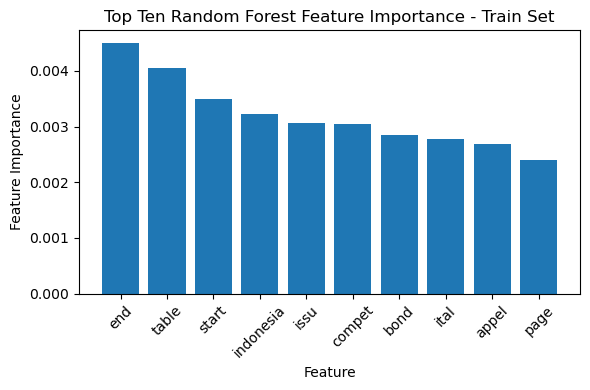

In [45]:
feature_importances = clf.feature_importances_
top_ten_indices = np.argsort(feature_importances)[::-1][:10]
feature_names = train_init_bow_df.columns
top_ten_feature_names = feature_names[top_ten_indices]
top_ten_importances = feature_importances[top_ten_indices]
plt.figure(figsize=(6, 4))
plt.bar(range(len(top_ten_importances)), top_ten_importances, tick_label=top_ten_feature_names)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Top Ten Random Forest Feature Importance - Train Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Logistic Regression

In [46]:
# center and standarize train and test
Xtrain_mean = np.mean(train_init_bow_df, axis=0)
Xtrain_std = np.std(train_init_bow_df, axis=0)
Xtrain_centered_std = (train_init_bow_df - Xtrain_mean) / Xtrain_std
Xtrain_centered_std = Xtrain_centered_std.fillna(0)

Xtest_centered_std = (test_init_bow_df - Xtrain_mean) / Xtrain_std
Xtest_centered_std = Xtest_centered_std.fillna(0)

In [47]:
# Fit a logistic regression model with lasso penalty (C=1)
lgr = LogisticRegression(penalty='l1', C=1, solver='liblinear')
lgr.fit(Xtrain_centered_std, y_train)

# Evaluate the model on the test data
accuracy_ = lgr.score(Xtest_centered_std, y_test)
missclassification_ = 1 - accuracy_
print('Logistic Regression with Word Frequency:')
print(f"Misclassification: {missclassification_:.5f}")
print(f"Accuracy: {accuracy_:.5f}")

Logistic Regression with Word Frequency:
Misclassification: 0.20805
Accuracy: 0.79195


### Sklearn's TF-IDF Representation

In [48]:
#sklearn 
tfidf_vectorizer = TfidfVectorizer(token_pattern = '[a-zA-Z]+')

# Repeat the process to make the DataFrame:
train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
train_tfidf_df = pd.DataFrame(train_tfidf_matrix.toarray(),
                        columns = tfidf_vectorizer.get_feature_names_out())

test_tfidf_matrix = tfidf_vectorizer.fit(X_train).transform(X_test)
test_tfidf_df = pd.DataFrame(test_tfidf_matrix.toarray(), 
                           columns = tfidf_vectorizer.get_feature_names_out())

#### Random Forest

In [49]:
# RF predict 
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(train_tfidf_df, y_train)

y_pred_ = clf.predict(test_tfidf_df)

In [50]:
misclassification = 1 - accuracy_score(y_test, y_pred_)
print('Random Forest with Sklearn TF-IDF')
print(f"Misclassification: {misclassification :.5f}")
print(f"Accuracy: { accuracy_score(y_test, y_pred_):.5f}")

Random Forest with Sklearn TF-IDF
Misclassification: 0.16107
Accuracy: 0.83893


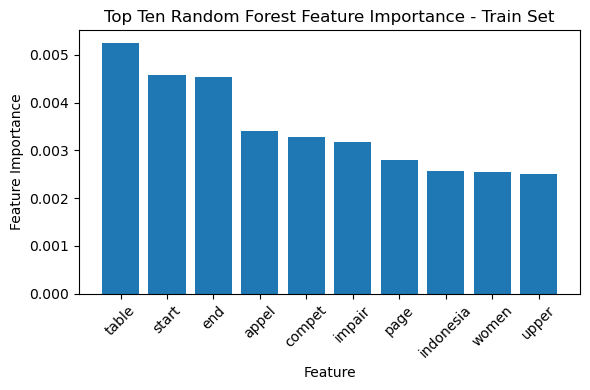

In [51]:
feature_importances = clf.feature_importances_
top_ten_indices = np.argsort(feature_importances)[::-1][:10]
feature_names = train_tfidf_df.columns
top_ten_feature_names = feature_names[top_ten_indices]
top_ten_importances = feature_importances[top_ten_indices]
plt.figure(figsize=(6, 4))
plt.bar(range(len(top_ten_importances)), top_ten_importances, tick_label=top_ten_feature_names)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Top Ten Random Forest Feature Importance - Train Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Logistic Regression

In [52]:
# center and standarize train and test
Xtrain_mean = np.mean(train_tfidf_df, axis=0)
Xtrain_std = np.std(train_tfidf_df, axis=0)
Xtrain_centered_std = (train_tfidf_df - Xtrain_mean) / Xtrain_std
Xtrain_centered_std = Xtrain_centered_std.fillna(0)

Xtest_centered_std = (test_tfidf_df - Xtrain_mean) / Xtrain_std
Xtest_centered_std = Xtest_centered_std.fillna(0)

In [53]:
# Fit a logistic regression model with lasso penalty (C=1)
lgr = LogisticRegression(penalty='l1', C=1, solver='liblinear')
lgr.fit(Xtrain_centered_std, y_train)

# Evaluate the model on the test data
accuracy_ = lgr.score(Xtest_centered_std, y_test)
missclassification_ = 1 - accuracy_
print('Logistic Regression with Sklearn TF-IDF:')
print(f"Misclassification: {missclassification_:.5f}")
print(f"Accuracy: {accuracy_:.5f}")

Logistic Regression with Sklearn TF-IDF:
Misclassification: 0.24161
Accuracy: 0.75839


### Manual TF-IDF Representation

In [54]:
#manual 
word_vectorizer = CountVectorizer(token_pattern = '[a-zA-Z]+')
# Now use this to set-up the same type of dataset as before:
train_bow_matrix = word_vectorizer.fit_transform(X_train)
train_bow_df = pd.DataFrame(train_bow_matrix.toarray(), 
                           columns = word_vectorizer.get_feature_names_out())

test_bow_matrix = word_vectorizer.fit(X_train).transform(X_test)
test_bow_df = pd.DataFrame(test_bow_matrix.toarray(), 
                           columns = word_vectorizer.get_feature_names_out())


# manual calculation
train_idf = train_bow_df.apply(lambda row: (row!=0).sum(), axis=0)

train_tf = train_bow_df / train_bow_df.sum(axis=0)
test_tf = test_bow_df / test_bow_df.sum(axis=0)

train_tfidf = train_tf * train_idf
test_tfidf = (test_tf * train_idf).fillna(0)

#### Random Forest

In [55]:
# RF predict 
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(train_tfidf, y_train)

y_pred = clf.predict(test_tfidf)

In [56]:
misclassification = 1 - accuracy_score(y_test, y_pred)
print('Random Forest with manual TF-IDF')
print(f"Misclassification: {misclassification :.5f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred) :.5f}")

Random Forest with manual TF-IDF
Misclassification: 0.16779
Accuracy: 0.83221


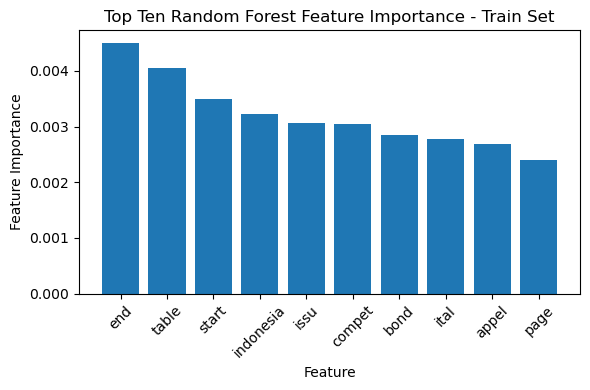

In [57]:
feature_importances = clf.feature_importances_
top_ten_indices = np.argsort(feature_importances)[::-1][:10]
feature_names = train_tfidf.columns
top_ten_feature_names = feature_names[top_ten_indices]
top_ten_importances = feature_importances[top_ten_indices]
plt.figure(figsize=(6, 4))
plt.bar(range(len(top_ten_importances)), top_ten_importances, tick_label=top_ten_feature_names)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Top Ten Random Forest Feature Importance - Train Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Logistic Regression

In [58]:
# center and standarize train and test
Xtrain_mean = np.mean(train_tfidf, axis=0)
Xtrain_std = np.std(train_tfidf, axis=0)
Xtrain_centered_std = (train_tfidf - Xtrain_mean) / Xtrain_std
Xtrain_centered_std = Xtrain_centered_std.fillna(0)

Xtest_centered_std = (test_tfidf - Xtrain_mean) / Xtrain_std
Xtest_centered_std = Xtest_centered_std.fillna(0)

In [59]:
# Fit a logistic regression model with lasso penalty (C=1)
lgr = LogisticRegression(penalty='l1', C=1, solver='liblinear')
lgr.fit(Xtrain_centered_std, y_train)

# Evaluate the model on the test data
accuracy_ = lgr.score(Xtest_centered_std, y_test)
missclassification_ = 1 - accuracy_
print('Logistic Regression with manual TF-IDF:')
print(f"Misclassification: {missclassification_:.5f}")
print(f"Accuracy: {accuracy_:.5f}")

Logistic Regression with manual TF-IDF:
Misclassification: 0.23490
Accuracy: 0.76510


### Gensim Package Representation

#### Random Forest

In [60]:
import gensim.downloader as api

wv_model = api.load('glove-wiki-gigaword-100')


In [61]:
def get_word_vector(document, model, n_dim):
    wv = np.zeros(n_dim) # init array same size as provided n_dim
    n = 0 # number of words with word vector
    
    # iterate over the words in the document
    tokens = nltk.word_tokenize(document)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [w.lower() for w in tokens if w.lower() not in ENGLISH_STOP_WORDS]
    
    for word in tokens:
        if word.lower() in model:
            wv = np.add(wv, model[word.lower()])
            n += 1
    if n > 0:
        wv = np.divide(wv, n)
    return wv

In [62]:
cv_five_fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2013)

In [63]:
doc_embeddings_df = pd.concat([pd.DataFrame(
    get_word_vector(doc, wv_model, 100).reshape(-1, 100)) for doc in companies['new_text']])

In [64]:
X, y = companies.loc[:, "new_text"].values, companies.loc[:, "priceMove"].values
rf_scores = cross_val_score(estimator = RandomForestClassifier(n_estimators=500), X = doc_embeddings_df, y=y, scoring = 'accuracy', 
                        cv = cv_five_fold, n_jobs = 5)

rf_scores

array([0.82828283, 0.84848485, 0.83838384, 0.84848485, 0.81818182])

In [65]:
missclassification_ = 1 - rf_scores.mean()
print('Random Forest with gensim:')
print(f"Misclassification: {missclassification_:.5f}")
print(f"Accuracy: {rf_scores.mean():.5f}")

Random Forest with gensim:
Misclassification: 0.16364
Accuracy: 0.83636


#### Logistic Regression

In [66]:
lr_scores = cross_val_score(estimator = LogisticRegression(), X = doc_embeddings_df, y=y, scoring = 'accuracy', 
                        cv = cv_five_fold, n_jobs = 5)

In [67]:
missclassification_ = 1 - lr_scores.mean()
print('Logistic Regression with gensim:')
print(f"Misclassification: {missclassification_:.5f}")
print(f"Accuracy: {lr_scores.mean():.5f}")

Logistic Regression with gensim:
Misclassification: 0.16566
Accuracy: 0.83434


### LSA Matrix Representation

#### Random Forest

In [68]:
cv_five_fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2013)
rf_scores = cross_val_score(estimator = RandomForestClassifier(n_estimators=500), X = W_svd_fomc_matrix, y=y, scoring = 'accuracy', 
                        cv = cv_five_fold, n_jobs = 5)

rf_scores

array([0.81818182, 0.80808081, 0.84848485, 0.83838384, 0.83838384])

In [69]:
missclassification_ = 1 - rf_scores.mean()
print('Random Forest with LSA:')
print(f"Misclassification: {missclassification_:.5f}")
print(f"Accuracy: {rf_scores.mean():.5f}")

Random Forest with LSA:
Misclassification: 0.16970
Accuracy: 0.83030


#### Logistic Regression

In [70]:
#cv_five_fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2013)
rf_scores = cross_val_score(estimator = LogisticRegression(), X = W_svd_fomc_matrix, y=y, scoring = 'accuracy', 
                        cv = cv_five_fold, n_jobs = 5)

rf_scores

array([0.80808081, 0.82828283, 0.83838384, 0.83838384, 0.85858586])

In [71]:
missclassification_ = 1 - rf_scores.mean()
print('Logistic Regression with LSA:')
print(f"Misclassification: {missclassification_:.5f}")
print(f"Accuracy: {rf_scores.mean():.5f}")

Logistic Regression with LSA:
Misclassification: 0.16566
Accuracy: 0.83434
